In [246]:
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import pandas as pd
from sklearn.metrics import classification_report


In [186]:
df = pd.read_csv("../data/engineered_features_multi_stock_data.csv",index_col="Date")
df.drop("Unnamed: 0",axis="columns",inplace=True)
df.head()

,Close,Volume,Target,RAV,Volitility,Buy_Sell_Strength,Weighted_Strength,Trend,Returns,Log_returns,AAPL,MSFT,NVDA,TSLA
Date,,,,,,,,,,,,,,
2015-02-06,26.495506,174826400,1,2.508224e+08,1.046604,0.266668,-0.162635,-0.007055,-0.008421,8.064544,True,False,False,False
2015-02-09,26.671505,155559200,1,2.247958e+08,1.096023,0.914897,0.287110,0.010177,0.006643,8.139062,True,False,False,False
2015-02-10,27.183905,248034000,1,2.123746e+08,1.149111,0.934671,0.507655,0.037193,0.019212,8.278700,True,False,False,False
2015-02-11,27.821060,294247200,1,2.185590e+08,1.245724,0.983471,0.650899,0.053246,0.023439,8.423923,True,False,False,False
2015-02-12,28.173054,297898000,1,2.314498e+08,1.339346,0.465967,-0.043803,0.043885,0.012652,8.471078,True,False,False,False


In [188]:
from sklearn.preprocessing import StandardScaler

X = df.drop("Target", axis="columns")
X_std = X.copy()
scaler = StandardScaler()
num_features = ['Close', 'Volume', 'RAV', 'Volitility', 'Buy_Sell_Strength', 'Weighted_Strength', 'Trend']
tickers = ['AAPL', 'MSFT', 'NVDA', 'TSLA']
for ticker in tickers:
    mask = X[ticker] == 1
    X_std.loc[mask, num_features] = scaler.fit_transform(X.loc[mask, num_features])


y = df.Target

C:\Users\dalu\AppData\Local\Temp\ipykernel_22036\3098634208.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.95380477  0.66382358  2.0556165  ... -1.1006561  -0.74756511
 -1.40813909]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_std.loc[mask, num_features] = scaler.fit_transform(X.loc[mask, num_features])


In [259]:
# def data_split(x,y,model):
#     tscv = TimeSeriesSplit(n_splits=5)
    
#     for train_idx, test_idx in tscv.split(X):
#         X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
#         y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
#         model.fit(X_train, y_train)
#         preds = model.predict(X_test)
    
#     print(classification_report(y_test,preds))
    
#     print(f'Train: {model.score(X_train,y_train)}')
#     print(f'Test: {model.score(X_test,y_test)}')
    
#     scores = cross_val_score(model, X, y, cv=tscv, scoring='accuracy')
#     print("Scores:", scores)
#     print("Mean:", scores.mean())

#     return X_test, y_test

In [268]:
def data_split(x,y,model):
    test_ratio = 0.2
    train_list, test_list = [], []
    
    for ticker, group in df.groupby(df[['AAPL','MSFT','NVDA','TSLA']].idxmax(axis=1).map(lambda x: x if pd.notna(x) else None)):
        group = group.sort_values('Date')  # ensure sorted by time
        split_idx = int(len(group) * (1 - test_ratio))
        train_list.append(group.iloc[:split_idx])
        test_list.append(group.iloc[split_idx:])

    train_df = pd.concat(train_list).sort_values('Date').reset_index(drop=True)
    test_df = pd.concat(test_list).sort_values('Date').reset_index(drop=True)
    
    X_train = train_df.drop(columns=['Target'])
    y_train = train_df['Target']
    
    X_test = test_df.drop(columns=['Target'])
    y_test = test_df['Target']
    
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    print(classification_report(y_test,preds))
    
    print(f'Train: {model.score(X_train,y_train)}')
    print(f'Test: {model.score(X_test,y_test)}')
    
    scores = cross_val_score(model, X, y, cv=tscv, scoring='accuracy')
    print("Scores:", scores)
    print("Mean:", scores.mean())

    return X_test, y_test

In [269]:
xgb = XGBClassifier(
    n_estimators=100,     
    learning_rate=0.08,    
    max_depth=3,         
    subsample=1.0,        
    colsample_bytree=0.8, 
    gamma=0,              
    reg_alpha=1,          
    reg_lambda=2,         
    random_state=42
)
data_split(X,y,xgb)

              precision    recall  f1-score   support

           0       0.44      0.39      0.41       988
           1       0.53      0.58      0.55      1167

    accuracy                           0.49      2155
   macro avg       0.48      0.48      0.48      2155
weighted avg       0.49      0.49      0.49      2155

Train: 0.5963057620817844
Test: 0.49280742459396754
Scores: [0.51199108 0.50139431 0.54043503 0.47462354 0.52649191]
Mean: 0.5109871723368655


(           Close     Volume           RAV  Volitility  Buy_Sell_Strength  \
 0      46.935463  692573000  5.937243e+08    1.645283           0.965530   
 1     231.279999  135702700  1.130020e+08   15.801932           0.926406   
 2     317.101318   24040000  2.155843e+07    8.276232           0.844679   
 3     233.190002  130442800  1.174883e+08   15.491407           0.322981   
 4      45.637337  755293000  6.254683e+08    1.644891           0.117379   
 ...          ...        ...           ...         ...                ...   
 2150  510.959991   24065400  1.830163e+07    6.116654           0.095339   
 2151  249.100006   17891929  4.003839e+07    6.819915           0.900764   
 2152  513.518494    6387641  1.618231e+07    6.132103           0.388691   
 2153  188.149994   89180834  1.577492e+08    5.938565           0.526582   
 2154  426.689209   38039420  8.715610e+07   11.718095           0.752337   
 
       Weighted_Strength     Trend   Returns  Log_returns   AAPL   MSFT   

In [270]:
data_split(X_std,y,xgb)

              precision    recall  f1-score   support

           0       0.44      0.39      0.41       988
           1       0.53      0.58      0.55      1167

    accuracy                           0.49      2155
   macro avg       0.48      0.48      0.48      2155
weighted avg       0.49      0.49      0.49      2155

Train: 0.5963057620817844
Test: 0.49280742459396754
Scores: [0.51199108 0.50139431 0.54043503 0.47462354 0.52649191]
Mean: 0.5109871723368655


(           Close     Volume           RAV  Volitility  Buy_Sell_Strength  \
 0      46.935463  692573000  5.937243e+08    1.645283           0.965530   
 1     231.279999  135702700  1.130020e+08   15.801932           0.926406   
 2     317.101318   24040000  2.155843e+07    8.276232           0.844679   
 3     233.190002  130442800  1.174883e+08   15.491407           0.322981   
 4      45.637337  755293000  6.254683e+08    1.644891           0.117379   
 ...          ...        ...           ...         ...                ...   
 2150  510.959991   24065400  1.830163e+07    6.116654           0.095339   
 2151  249.100006   17891929  4.003839e+07    6.819915           0.900764   
 2152  513.518494    6387641  1.618231e+07    6.132103           0.388691   
 2153  188.149994   89180834  1.577492e+08    5.938565           0.526582   
 2154  426.689209   38039420  8.715610e+07   11.718095           0.752337   
 
       Weighted_Strength     Trend   Returns  Log_returns   AAPL   MSFT   

In [271]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=200, class_weight='balanced', max_depth=3, random_state=42, min_samples_split=5, bootstrap=False)

data_split(X,y,rf_classifier)

              precision    recall  f1-score   support

           0       0.47      0.76      0.58       988
           1       0.58      0.28      0.37      1167

    accuracy                           0.50      2155
   macro avg       0.52      0.52      0.48      2155
weighted avg       0.53      0.50      0.47      2155

Train: 0.547746282527881
Test: 0.4979118329466357
Scores: [0.49804796 0.50864473 0.5376464  0.48689347 0.51645287]
Mean: 0.5095370886781929


(           Close     Volume           RAV  Volitility  Buy_Sell_Strength  \
 0      46.935463  692573000  5.937243e+08    1.645283           0.965530   
 1     231.279999  135702700  1.130020e+08   15.801932           0.926406   
 2     317.101318   24040000  2.155843e+07    8.276232           0.844679   
 3     233.190002  130442800  1.174883e+08   15.491407           0.322981   
 4      45.637337  755293000  6.254683e+08    1.644891           0.117379   
 ...          ...        ...           ...         ...                ...   
 2150  510.959991   24065400  1.830163e+07    6.116654           0.095339   
 2151  249.100006   17891929  4.003839e+07    6.819915           0.900764   
 2152  513.518494    6387641  1.618231e+07    6.132103           0.388691   
 2153  188.149994   89180834  1.577492e+08    5.938565           0.526582   
 2154  426.689209   38039420  8.715610e+07   11.718095           0.752337   
 
       Weighted_Strength     Trend   Returns  Log_returns   AAPL   MSFT   

In [272]:
from sklearn.ensemble import RandomForestClassifier
rf_std_classifier = RandomForestClassifier(n_estimators=200, class_weight='balanced', max_depth=3, random_state=42, min_samples_split=3, bootstrap=False)

rf_X_test, rf_y_test = data_split(X_std,y,rf_std_classifier)

              precision    recall  f1-score   support

           0       0.47      0.76      0.58       988
           1       0.58      0.28      0.38      1167

    accuracy                           0.50      2155
   macro avg       0.52      0.52      0.48      2155
weighted avg       0.53      0.50      0.47      2155

Train: 0.546003717472119
Test: 0.49837587006960554
Scores: [0.49804796 0.50697156 0.53597323 0.48577803 0.51645287]
Mean: 0.5086447295036252


In [276]:
from sklearn.metrics import precision_recall_curve, f1_score

# Get prediction probabilities from your model
y_probs = rf_std_classifier.predict_proba(rf_X_test)[:, 1]  # probabilities for class 1

precisions, recalls, thresholds = precision_recall_curve(rf_y_test, y_probs)

# Compute F1 for each threshold
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)

# Find best threshold for highest F1
best_idx = f1_scores.argmax()
best_thresh = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best Threshold: {best_thresh:.3f}, Best F1: {best_f1:.3f}")

# Evaluate using that threshold
y_pred_opt = (y_probs >= 0.493).astype(int)
print(classification_report(rf_y_test, y_pred_opt))


Best Threshold: 0.406, Best F1: 0.703
              precision    recall  f1-score   support

           0       0.48      0.71      0.57       988
           1       0.58      0.34      0.43      1167

    accuracy                           0.51      2155
   macro avg       0.53      0.52      0.50      2155
weighted avg       0.53      0.51      0.49      2155



In [275]:
import numpy as np
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(rf_y_test, y_probs)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
optimal_threshold

0.49312409724597134

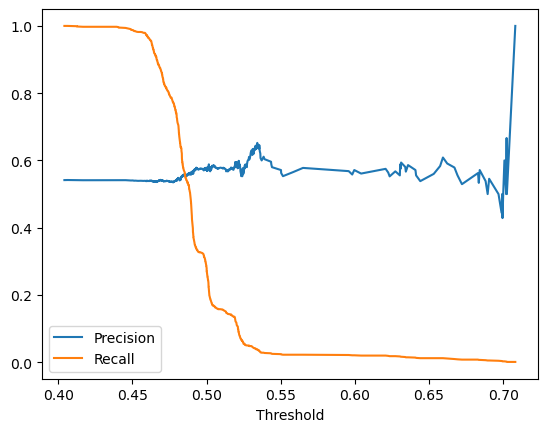

In [277]:
import matplotlib.pyplot as plt

plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.xlabel('Threshold')
plt.legend()
plt.show()


In [278]:
from lightgbm import LGBMClassifier

lgb = LGBMClassifier(
    n_estimators=200,
    num_leaves=15,
    learning_rate=0.01,
    max_depth=-8,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha = 5.0,
    reg_lambda = 3.0,
    class_weight='balanced',
    random_state=42
)

data_split(X,y,lgb)



# Cross-validation
scores = cross_val_score(lgb, X, y, cv=tscv, scoring='f1')
print(f"Mean CV F1: {scores.mean():.3f}")


[LightGBM] [Info] Number of positive: 4561, number of negative: 4047
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2303
[LightGBM] [Info] Number of data points in the train set: 8608, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
              precision    recall  f1-score   support

           0       0.46      0.74      0.57       988
           1       0.55      0.27      0.36      1167

    accuracy                           0.48      2155
   macro avg       0.50      0.50      0.46      2155
weighted avg       0.51      0.48      0.45      2155

Train: 0.6009526022304833
Test: 0.4835266821345708
[LightGBM] [Info] Number of positive: 951, number of negative: 847
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the ov

In [279]:
from lightgbm import LGBMClassifier

lgb = LGBMClassifier(
    n_estimators=200,
    learning_rate=0.01,
    max_depth=-8,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha = 5.0,
    reg_lambda = 3.0,
    class_weight='balanced',
    random_state=42
)

data_split(X_std,y,lgb)


# Cross-validation
scores = cross_val_score(lgb, X, y, cv=tscv, scoring='f1')
print(f"Mean CV F1: {scores.mean():.3f}")


[LightGBM] [Info] Number of positive: 4561, number of negative: 4047
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2303
[LightGBM] [Info] Number of data points in the train set: 8608, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
              precision    recall  f1-score   support

           0       0.46      0.68      0.55       988
           1       0.54      0.31      0.40      1167

    accuracy                           0.48      2155
   macro avg       0.50      0.50      0.47      2155
weighted avg       0.50      0.48      0.47      2155

Train: 0.6463754646840149
Test: 0.48259860788863107
[LightGBM] [Info] Number of positive: 951, number of negative: 847
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the o

In [280]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression(fit_intercept=False, class_weight="balanced", C=0.2)

data_split(X,y,log)

              precision    recall  f1-score   support

           0       0.67      0.01      0.02       988
           1       0.54      1.00      0.70      1167

    accuracy                           0.54      2155
   macro avg       0.60      0.50      0.36      2155
weighted avg       0.60      0.54      0.39      2155

Train: 0.5284618959107806
Test: 0.5438515081206496
Scores: [0.47796988 0.47629671 0.52258784 0.46681539 0.54322365]
Mean: 0.49737869492470715


(           Close     Volume           RAV  Volitility  Buy_Sell_Strength  \
 0      46.935463  692573000  5.937243e+08    1.645283           0.965530   
 1     231.279999  135702700  1.130020e+08   15.801932           0.926406   
 2     317.101318   24040000  2.155843e+07    8.276232           0.844679   
 3     233.190002  130442800  1.174883e+08   15.491407           0.322981   
 4      45.637337  755293000  6.254683e+08    1.644891           0.117379   
 ...          ...        ...           ...         ...                ...   
 2150  510.959991   24065400  1.830163e+07    6.116654           0.095339   
 2151  249.100006   17891929  4.003839e+07    6.819915           0.900764   
 2152  513.518494    6387641  1.618231e+07    6.132103           0.388691   
 2153  188.149994   89180834  1.577492e+08    5.938565           0.526582   
 2154  426.689209   38039420  8.715610e+07   11.718095           0.752337   
 
       Weighted_Strength     Trend   Returns  Log_returns   AAPL   MSFT   

In [283]:
from sklearn.metrics import precision_recall_curve, f1_score

# Get prediction probabilities from your model
y_probs = log.predict_proba(log_X_test)[:, 1]  # probabilities for class 1

precisions, recalls, thresholds = precision_recall_curve(log_y_test, y_probs)

# Compute F1 for each threshold
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)

# Find best threshold for highest F1
best_idx = f1_scores.argmax()
best_thresh = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best Threshold: {best_thresh:.3f}, Best F1: {best_f1:.3f}")

# Evaluate using that threshold
y_pred_opt = (y_probs >= best_thresh).astype(int)
print(classification_report(log_y_test, y_pred_opt))


Best Threshold: 0.500, Best F1: nan
              precision    recall  f1-score   support

           0       0.46      1.00      0.63       825
           1       0.00      0.00      0.00       968

    accuracy                           0.46      1793
   macro avg       0.23      0.50      0.31      1793
weighted avg       0.21      0.46      0.29      1793



C:\Users\dalu\AppData\Local\Temp\ipykernel_22036\584236959.py:9: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precisions * recalls) / (precisions + recalls)


In [284]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression(fit_intercept=False, class_weight="balanced", C=0.2)

data_split(X_std,y,log)

              precision    recall  f1-score   support

           0       0.67      0.01      0.02       988
           1       0.54      1.00      0.70      1167

    accuracy                           0.54      2155
   macro avg       0.60      0.50      0.36      2155
weighted avg       0.60      0.54      0.39      2155

Train: 0.5284618959107806
Test: 0.5438515081206496
Scores: [0.47796988 0.47629671 0.52258784 0.46681539 0.54322365]
Mean: 0.49737869492470715


(           Close     Volume           RAV  Volitility  Buy_Sell_Strength  \
 0      46.935463  692573000  5.937243e+08    1.645283           0.965530   
 1     231.279999  135702700  1.130020e+08   15.801932           0.926406   
 2     317.101318   24040000  2.155843e+07    8.276232           0.844679   
 3     233.190002  130442800  1.174883e+08   15.491407           0.322981   
 4      45.637337  755293000  6.254683e+08    1.644891           0.117379   
 ...          ...        ...           ...         ...                ...   
 2150  510.959991   24065400  1.830163e+07    6.116654           0.095339   
 2151  249.100006   17891929  4.003839e+07    6.819915           0.900764   
 2152  513.518494    6387641  1.618231e+07    6.132103           0.388691   
 2153  188.149994   89180834  1.577492e+08    5.938565           0.526582   
 2154  426.689209   38039420  8.715610e+07   11.718095           0.752337   
 
       Weighted_Strength     Trend   Returns  Log_returns   AAPL   MSFT   

In [238]:
# from sklearn.ensemble import RandomForestClassifier, VotingClassifier

# rf = RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=42)
# lr = LogisticRegression(class_weight='balanced', max_iter=1000)
# xgb = XGBClassifier(n_estimators=200, use_label_encoder=False, eval_metric='logloss', random_state=42)

# v = VotingClassifier(estimators=[('rf', rf), ('lr', lr), ('xgb', xgb)], voting='soft')



# for train_idx, test_idx in tscv.split(X_std):
#     v_X_train, v_X_test = X_std.iloc[train_idx], X_std.iloc[test_idx]
#     v_y_train, v_y_test = y.iloc[train_idx], y.iloc[test_idx]

#     v.fit(v_X_train,v_y_train)
#     v_pred = v.predict(v_X_test)
#     v_probs = v.predict_proba(X_test)[:,1]
#     y_pred = (probs >= 0.5).astype(int) 

# print(classification_report(v_y_test,v_pred))
# print(f'Train: {v.score(v_X_train,v_y_train)}')
# print(f'Test: {v.score(v_X_test,v_y_test)}')

# scores = cross_val_score(v, X, y, cv=tscv, scoring='accuracy')
# print("Scores:", scores)
# print("Mean:", scores.mean())
 # adjust threshold if needed


In [197]:
import numpy as np
np.bincount(y)

array([5035, 5728], dtype=int64)

In [198]:
print("xgboost normal",np.bincount(preds))
print("xgboost std",np.bincount(std_preds))
print("rf normal",np.bincount(rf_pred))
print("rf std",np.bincount(rf_std_pred))

xgboost normal [ 234 1559]
xgboost std [1717   76]
rf normal [850 943]
rf std [841 952]


In [199]:
pd.DataFrame({
    'feature': X.columns,
    'importance_before': rf_classifier.feature_importances_,
    'importance_after': rf_std_classifier.feature_importances_,
}).sort_values('importance_before', ascending=False)

,feature,importance_before,importance_after
7,Returns,0.187211,0.181571
2,RAV,0.147089,0.161016
4,Buy_Sell_Strength,0.127989,0.145201
5,Weighted_Strength,0.122289,0.129612
0,Close,0.103094,0.096351
1,Volume,0.096170,0.075545
3,Volitility,0.092091,0.097002
8,Log_returns,0.068565,0.063649
6,Trend,0.048425,0.040034
12,TSLA,0.003136,0.002891


In [287]:
rf_X_test.head()

,Close,Volume,RAV,Volitility,Buy_Sell_Strength,Weighted_Strength,Trend,Returns,Log_returns,AAPL,MSFT,NVDA,TSLA
0,46.935463,692573000,5.937243e+08,1.645283,0.965530,0.543035,-0.048846,0.084713,12.458125,False,False,True,False
1,231.279999,135702700,1.130020e+08,15.801932,0.926406,0.512066,-0.056184,0.073275,43.045538,False,False,False,True
2,317.101318,24040000,2.155843e+07,8.276232,0.844679,0.384355,-0.057114,0.017063,55.221980,False,True,False,False
3,233.190002,130442800,1.174883e+08,15.491407,0.322981,-0.196537,-0.074962,0.008258,42.837232,False,False,False,True
4,45.637337,755293000,6.254683e+08,1.644891,0.117379,-0.462040,-0.076714,-0.027658,11.857631,False,False,True,False
